## The program below extracts the features from the 4 datasets: Balabit, Chaoshen, DFL and TWOS and teaches the models extracted behaviour. 
The datasets consist of mouse actions


In [1]:
%pip install -r requirments.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
## IMPORTING THE CLASSES ## 
from utils.consts import * ## const variables are there, so paths and extraction features ##
from utils. plotting import * ## plotting ##
from data_reader_babalit import * ## the class which reads balabit dataset ##
from data_reader_chaoshen import * ## the class which reads chaoshen datasets TODO There are several issues with this dataset -> explained later ##
from data_reader_singapur import * ## the class which reads singapur dataset##
from data_reader_dfl import * ## the class which reads dfl dataset ## 

from nonlegality_analyser import * ## the class which analyses the datasets without 0 1 labels --> splitting samples is being done there ##  
from legality_analyser import * ## the class which analyses the datasets with 0 1 labels --> splitting samples is being done there ##  


from SVMmodel import *
from RandomForestModel import *
from OneClassSVMModel import *
from IsolationForestModel import *

import random

# BALABIT DATASET FEATURE EXTRACTION

In [4]:
## Specyfing the USERS ## 
users = [7,9,15,16,20,21,23,29, 35] ## those are all users 
## Creating the object which analyses the dataset ## 
balabit_reader = DataReaderBalabit(BALABIT, users, False, limit = 1000) ## the arguments are DATASET, users, supervised, how many records should be procesed ##
balabit_reader.processDataWithoutLabels() ## creating the data without labels ##



File already exist


In [5]:
## getting path from the reader ##
print(balabit_reader.fileName) 
path = balabit_reader.getFileName()

## creating analyser class ## 
balabitAnalyser = nonLegalityAnalyser(path)
## counting how many actions were extracted ## 
print(balabitAnalyser.countActions())

processed_files\balabit_dataset_users[7, 9, 15, 16, 20, 21, 23, 29, 35]_limit1000_labelsFalse.csv
type_of_action     1    3    4
userid                        
7                679  812   88
9                798  830  107
15               547  641   89
16               538  608  113
20              1141  823   95
21               704  550   90
23               494  703   61
29               357  662  112
35               672  617   94


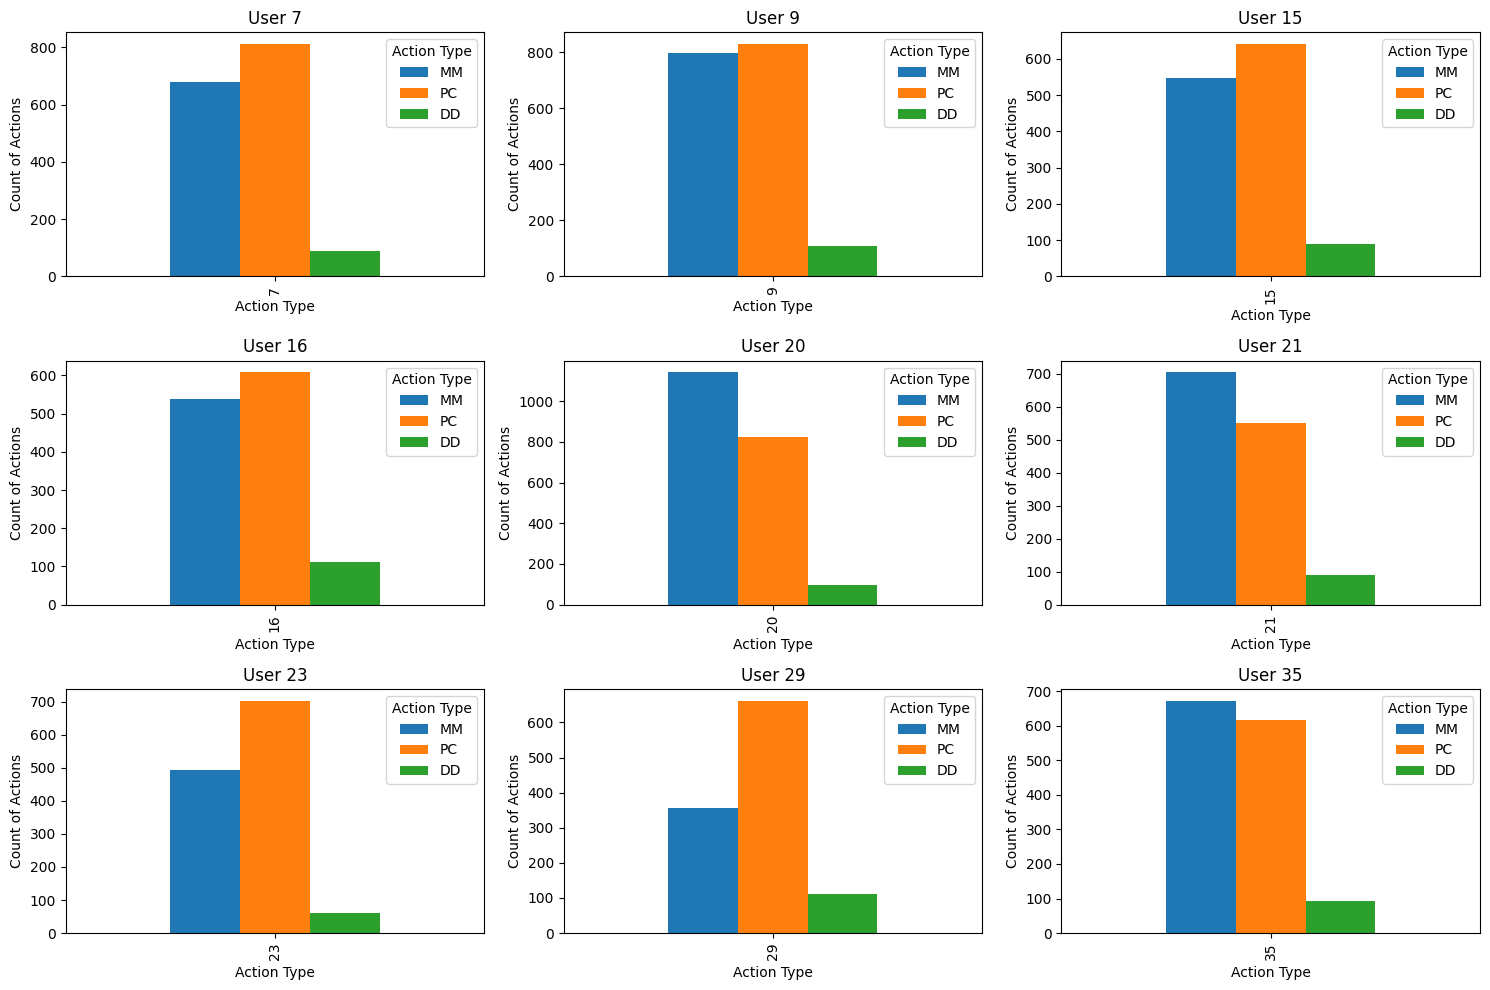

In [6]:
## histogram of actions ## 
balabitAnalyser.plotActionHistograms()

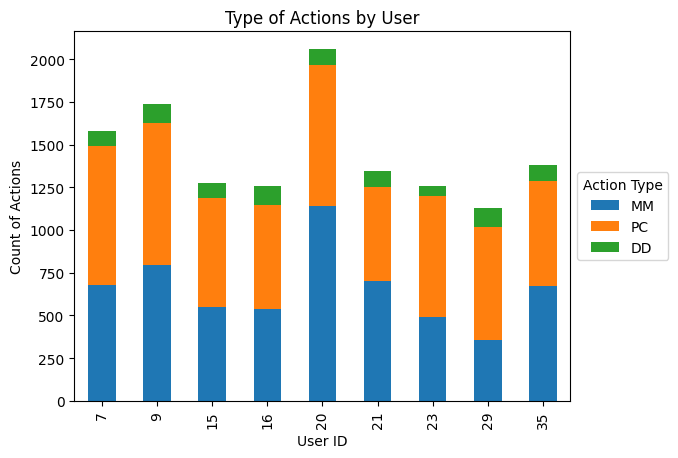

In [6]:
balabitAnalyser.plotTypeOfActions(True)

The actions are represented by 3 variables:
- MM (Mouse Move action) the user moves the cursor from x1,y1 to x2,y2 point, 
- PC (Process and Click action) the user moves the cursor from x1,y1 point to x2,y2 point and then proceeds to click the mouse,
- DD (Drag and drop action) the user drags something from first point to another one.

# BALABIT TEACHING THE MODELS ##
## Supervised part:
RandomForest and SVM 


In [1]:
from RandomForestModel import *


User 7 is being analyzed:


CV Accuracy: 0.92 (+/- 0.03)
Test Accuracy: 0.71
7: 0.902 threshold: 0.334
User 9 is being analyzed:
CV Accuracy: 0.95 (+/- 0.03)
Test Accuracy: 0.78
9: 0.969 threshold: 0.378
User 15 is being analyzed:
CV Accuracy: 0.75 (+/- 0.05)
Test Accuracy: 0.75
15: 0.819 threshold: 0.525
User 16 is being analyzed:
CV Accuracy: 0.73 (+/- 0.06)
Test Accuracy: 0.72
16: 0.783 threshold: 0.567
User 20 is being analyzed:
CV Accuracy: 0.84 (+/- 0.05)
Test Accuracy: 0.78
20: 0.869 threshold: 0.502
User 21 is being analyzed:
CV Accuracy: 0.77 (+/- 0.04)
Test Accuracy: 0.68
21: 0.801 threshold: 0.472
User 23 is being analyzed:
CV Accuracy: 0.73 (+/- 0.07)
Test Accuracy: 0.71
23: 0.792 threshold: 0.520
User 29 is being analyzed:
CV Accuracy: 0.80 (+/- 0.05)
Test Accuracy: 0.77
29: 0.869 threshold: 0.476
User 35 is being analyzed:
CV Accuracy: 0.71 (+/- 0.07)
Test Accuracy: 0.61
35: 0.733 threshold: 0.454


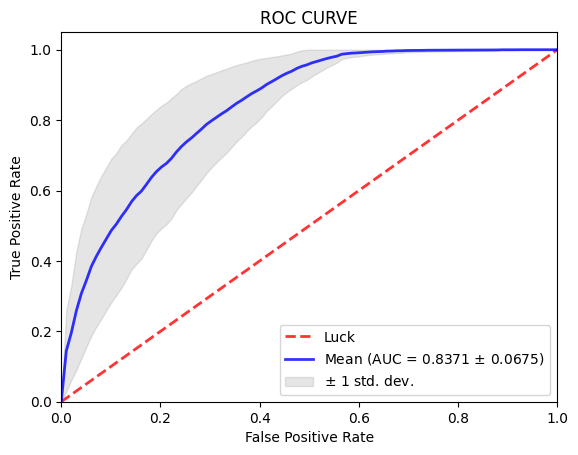

In [10]:
# shuffle var will be used later in order to mix the data ## 
shuffle = True
## dictionaries of fpr tpr ## 
fpr = {}
tpr = {}
roc_auc = {}

# ONE USER IS ALWAYS LEGAL ##
for legalUser in users:
    ## this function gets all samples of legaluser and then randomly selects the samples from other users - The data will be balanced ## 
    dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser)
    ## the last label is 1 or -1
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    ## train test split --> shuffle is used there ## if not used then data will be divided as x[0:halfTrainSamples] concatenate with X[positiveSamples: positiveSamples + trainHalfSamples]
    ## where positiveSamples is len(X/2)
    
    X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users, weight = 'balanced')
    ## evaluating the model, the variables are X_train, y_train, X_validation, y_validation, scale --> use standardScler, and legalUser
    fpr[legalUser], tpr[legalUser], thr, precission_user, recall_user, average_precision_use = model.evaluate(X_train, y_train, X_validation, y_validation, scale = True, user = legalUser, num_actions = 1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## Equal Error Rate //brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")

plotROCs(fpr, tpr, roc_auc, users)


In [10]:
from SVMmodel import *

User 7 is being analyzed:
CV Accuracy: 0.84 (+/- 0.05)
Test Accuracy: 0.84
7: 0.996 threshold: 0.527
User 9 is being analyzed:
CV Accuracy: 0.86 (+/- 0.03)
Test Accuracy: 0.89
9: 1.000 threshold: 0.487
User 15 is being analyzed:
CV Accuracy: 0.72 (+/- 0.06)
Test Accuracy: 0.73
15: 0.962 threshold: 0.507
User 16 is being analyzed:
CV Accuracy: 0.71 (+/- 0.04)
Test Accuracy: 0.69
16: 0.947 threshold: 0.523
User 20 is being analyzed:
CV Accuracy: 0.79 (+/- 0.05)
Test Accuracy: 0.78
20: 0.964 threshold: 0.530
User 21 is being analyzed:
CV Accuracy: 0.72 (+/- 0.08)
Test Accuracy: 0.72
21: 0.944 threshold: 0.505
User 23 is being analyzed:
CV Accuracy: 0.72 (+/- 0.06)
Test Accuracy: 0.70
23: 0.929 threshold: 0.527
User 29 is being analyzed:
CV Accuracy: 0.73 (+/- 0.07)
Test Accuracy: 0.75
29: 0.969 threshold: 0.479
User 35 is being analyzed:
CV Accuracy: 0.71 (+/- 0.04)
Test Accuracy: 0.75
35: 0.958 threshold: 0.507


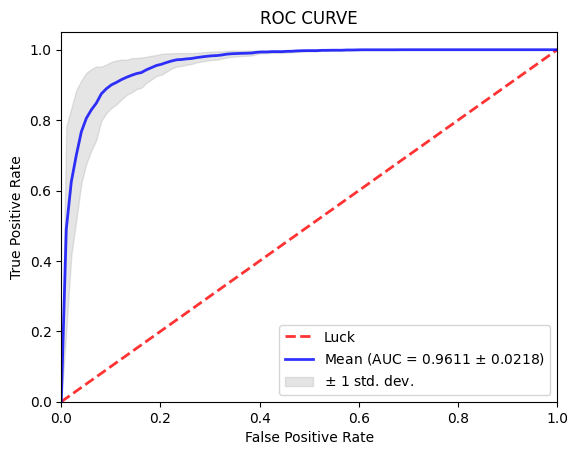

In [12]:
shuffle = True
fpr = {}
tpr = {}
roc_auc = {}

for legalUser in users:
    dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = SVMModel(dataset, users, weight = None)
    fpr[legalUser], tpr[legalUser], thr = model.evaluate(X_train, y_train, X_validation, y_validation, legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")


plotROCs(fpr, tpr, roc_auc, users)

As its visible the results for both of the algorithms are satisfactionary

In [ ]:
# shuffle var will be used later in order to mix the data ## 
shuffle = True
## dictionaries of fpr tpr ## 
fpr = {}
tpr = {}
roc_auc = {}

# ONE USER IS ALWAYS LEGAL ##
for legalUser in users:
    ## this function gets all samples of legaluser and then randomly selects the samples from other users - The data will be balanced ## 
    dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser)
    ## the last label is 1 or -1
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    ## train test split --> shuffle is used there ## if not used then data will be divided as x[0:halfTrainSamples] concatenate with X[positiveSamples: positiveSamples + trainHalfSamples]
    ## where positiveSamples is len(X/2)
    
    X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)

    model = SVMModel(dataset, users, weight= None)
    ## evaluating the model, the variables are X_train, y_train, X_validation, y_validation, scale --> use standardScler, and legalUser
    best_params= model.getBestParams(X_train, y_train, X_validation, y_validation)
   

## Unsupervised  algorithms 
One class SVM and Isolation Forest

## One Class SVM

In [11]:
from OneClassSVMModel import *

User 7 is being analyzed:


Test Accuracy: 0.57
7: 0.7021912169177246 threshold: -28.28555165596241
User 9 is being analyzed:
Test Accuracy: 0.55
9: 0.694016498981914 threshold: -33.6279915465279
User 15 is being analyzed:
Test Accuracy: 0.54
15: 0.5885021008987952 threshold: -16.135873572702405
User 16 is being analyzed:
Test Accuracy: 0.57
16: 0.6391230666924084 threshold: -17.791534814384487
User 20 is being analyzed:
Test Accuracy: 0.51
20: 0.5365326243844456 threshold: -47.00445140185061
User 21 is being analyzed:
Test Accuracy: 0.57
21: 0.6899810370593629 threshold: -38.542291712742745
User 23 is being analyzed:
Test Accuracy: 0.59
23: 0.7247941353685479 threshold: -41.39693256675982
User 29 is being analyzed:
Test Accuracy: 0.52
29: 0.4896003697646306 threshold: -48.26315867527007
User 35 is being analyzed:
Test Accuracy: 0.58
35: 0.736000758397175 threshold: -38.04377268917362


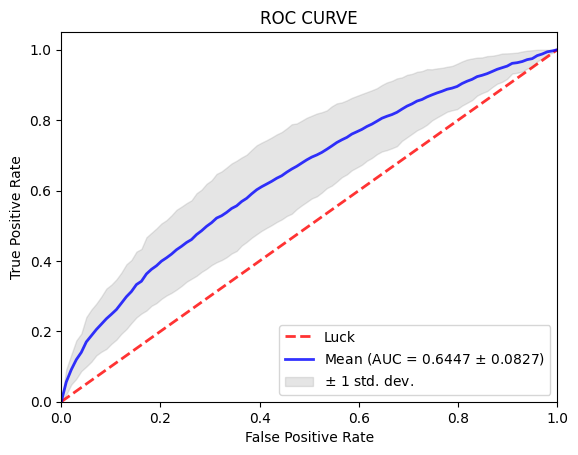

In [12]:
fpr = {}
tpr = {}
roc_auc = {}
shuffle = True
for legalUser in users:
    dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    y_validation = np.where(y_validation == 0, -1, y_validation)
    
    model = OneClassSVMModel(dataset, users)
    fpr[legalUser], tpr[legalUser], thr = model.evaluate(X_train, y_train, X_validation, y_validation, legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja 
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(str(legalUser) + ": " + str(roc_auc[legalUser])+" threshold: "+str(threshold))

plotROCs(fpr, tpr, roc_auc, users)

## Isolation Forest

In [5]:
from IsolationForestModel import *

User 7 is being analyzed:
Test Accuracy: 0.52
7: 0.5318430392582936 threshold: 0.06827348322561075
User 9 is being analyzed:
Test Accuracy: 0.53
9: 0.6294146721385135 threshold: 0.06479068300635919
User 15 is being analyzed:
Test Accuracy: 0.50
15: 0.6814956256075544 threshold: 0.07103910719386003
User 16 is being analyzed:
Test Accuracy: 0.49
16: 0.5520571399915465 threshold: 0.06230499871865732
User 20 is being analyzed:
Test Accuracy: 0.51
20: 0.4587678404553564 threshold: 0.07132407151609078
User 21 is being analyzed:
Test Accuracy: 0.52
21: 0.6224152191894128 threshold: 0.06491359268051379
User 23 is being analyzed:
Test Accuracy: 0.58
23: 0.7647691579536166 threshold: 0.06856496445932782
User 29 is being analyzed:
Test Accuracy: 0.50
29: 0.5311850311850311 threshold: 0.07764872910899849
User 35 is being analyzed:
Test Accuracy: 0.56
35: 0.7777192348905083 threshold: 0.08475351019095227


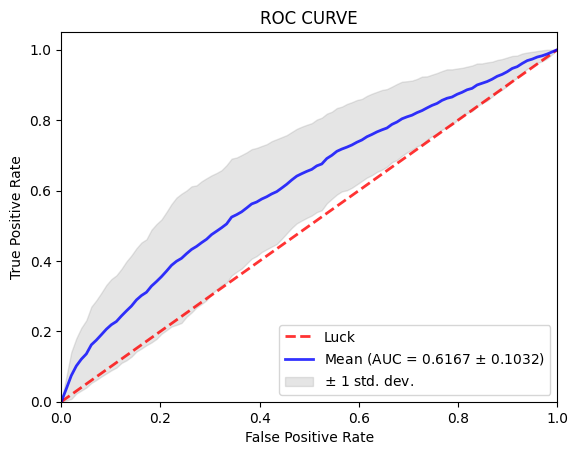

In [6]:
fpr = {}
tpr = {}
roc_auc = {}
shuffle = True
for legalUser in users:
    dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    y_validation = np.where(y_validation == 0, -1, y_validation)

    model = IsolationForestModel(dataset, users)
    fpr[legalUser], tpr[legalUser], thr = model.evaluate(X_train, y_train, X_validation, y_validation, legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja 
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(str(legalUser) + ": " + str(roc_auc[legalUser])+" threshold: "+str(threshold))

plotROCs(fpr, tpr, roc_auc, users)

Using unsupervised algorithms doesn't yeald better results.

# Checking which features are important for Random Forest
# Feature importance method

In [66]:
## choose legalUser randomly and create dataset for him ## 
legalUser = random.choice(users)
dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser)
X = dataset[:, 0:-1]
y = dataset[:, -1]
X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
model = RandomForestModel(dataset, users)
feature_importance = model.calculateFeatureImportance(X_train, y_train, X_validation)
df1 = balabitAnalyser.returnDataframe()


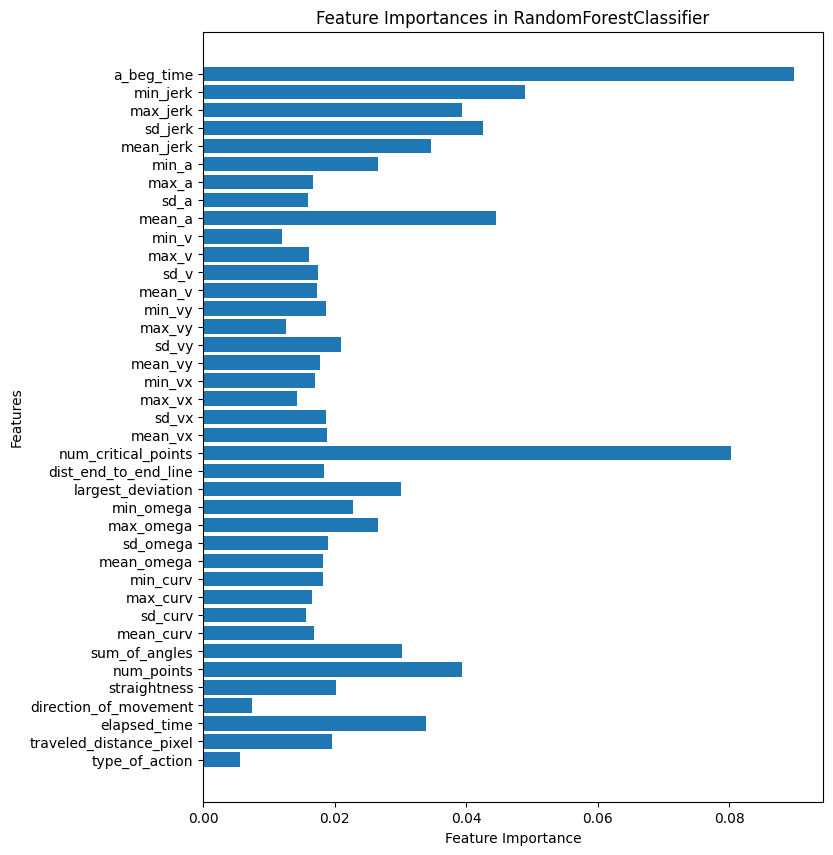

In [67]:
model.plotFeatureImportance(feature_importance, X, df1)

## Permutation Importance method

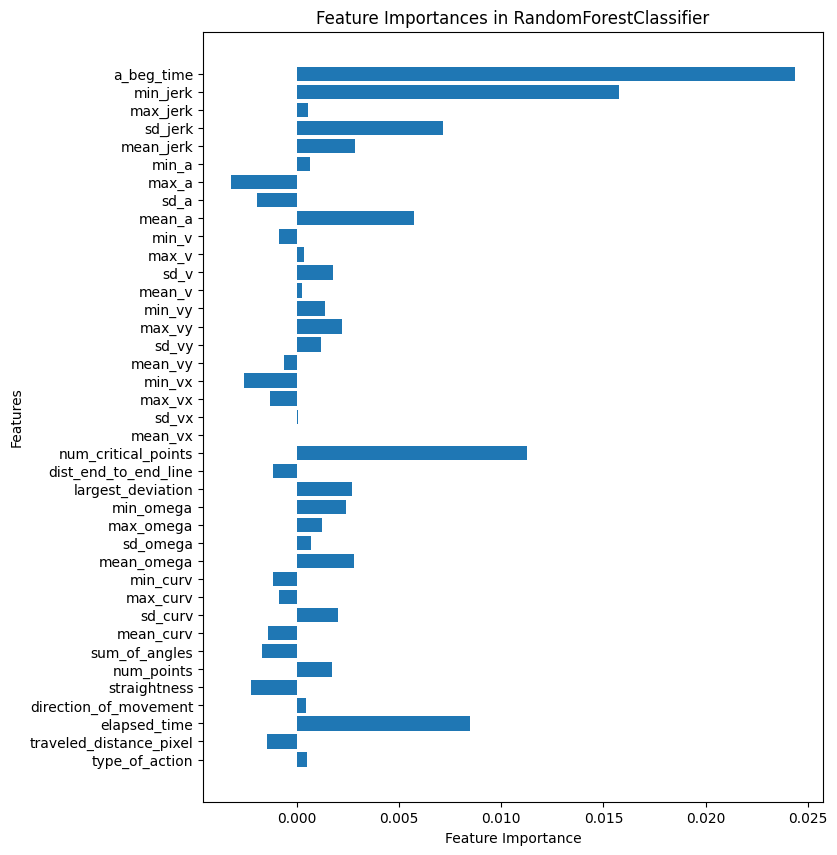

In [68]:
permutationImportance = model.calculatePermutationImportance(X_train, y_train, X_validation, y_validation)
model.plotFeatureImportance(permutationImportance, X, df1)

The most importants variables are :
- a_beg_time (acceleration in the begginng),
- jerk variables,
- number_of_critical_points (the amount of times the mouse is changing the direction)
- acceleration,
- straightness.

It all depends on the user, yet summarazing those are the ones which contribute the most.

#

# Creating datasets using the test files too  (works only for BALABIT) 
Labeling is being done during feature extraction and not in the end  of the process 

## Random Forest

In [18]:
users = [7,9,15,16,20,21,23,29, 35]
balabit_reader = DataReaderBalabit(BALABIT, users, True, limit = 1000) ## the arguments are DATASET, users, supervised = True, how many records should be procesed ##

User 7 is being analyzed:
CV Accuracy: 0.93 (+/- 0.03)
Test Accuracy: 0.75
7: 0.999 threshold: 0.346
User 9 is being analyzed:
CV Accuracy: 0.96 (+/- 0.03)
Test Accuracy: 0.94
9: 1.000 threshold: 0.632
User 15 is being analyzed:
CV Accuracy: 0.74 (+/- 0.06)
Test Accuracy: 0.70
15: 0.965 threshold: 0.495
User 16 is being analyzed:
CV Accuracy: 0.69 (+/- 0.04)
Test Accuracy: 0.68
16: 0.952 threshold: 0.501
User 20 is being analyzed:
CV Accuracy: 0.83 (+/- 0.04)
Test Accuracy: 0.81
20: 0.989 threshold: 0.507
User 21 is being analyzed:
CV Accuracy: 0.72 (+/- 0.04)
Test Accuracy: 0.72
21: 0.959 threshold: 0.496
User 23 is being analyzed:
CV Accuracy: 0.71 (+/- 0.05)
Test Accuracy: 0.67
23: 0.921 threshold: 0.496
User 29 is being analyzed:
CV Accuracy: 0.76 (+/- 0.05)
Test Accuracy: 0.76
29: 0.987 threshold: 0.490
User 35 is being analyzed:
CV Accuracy: 0.67 (+/- 0.06)
Test Accuracy: 0.64
35: 0.934 threshold: 0.458


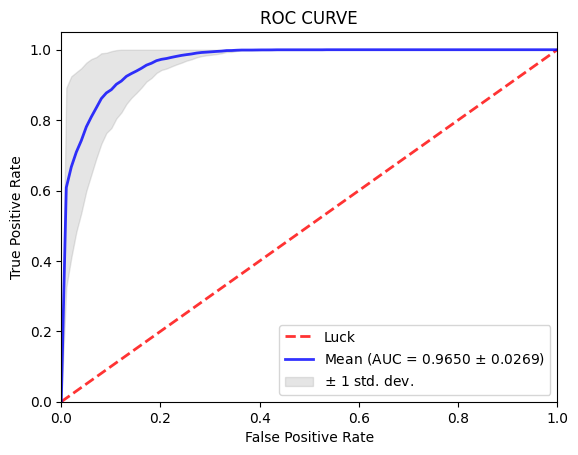

In [19]:
shuffle = True
## dictionaries of fpr tpr ## 
fpr = {}
tpr = {}
roc_auc = {}

for legalUser in users:
    # the function below has 3 variables - legalser (which of the sessions are legal), training - use training files only, test - use test files and parse CSV to check the legality ##
    balabit_reader.processDataWithLabels(legalUser, training = True, test = True)
    # the rest is the same as in previous attempts ##
    path = balabit_reader.getFileName()
    legality_analyser = legalityAnalyser(path)
    ## balanced = True - it will create balanced dataset // when balanced is False then  every false action of the dataset will be used, ratio legal to illegal will be  something like 1:8 
    dataset = legality_analyser.createTrainingData(balanced = True)

    ## the last label is 0 and 1
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
   
    X_train, X_validation, y_train, y_validation = legality_analyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users)
    ## evaluating the model, the variables are X_train, y_train, X_validation, y_validation, scale --> use standardScler, and legalUser
    fpr[legalUser], tpr[legalUser], thr = model.evaluate(X_train, y_train, X_validation, y_validation, scale = True, user = legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")

plotROCs(fpr, tpr, roc_auc, users)

## SVM

File already exist
User 7 is being analyzed:
CV Accuracy: 0.88 (+/- 0.03)
Test Accuracy: 0.89
7: 0.999 threshold: 0.559
File already exist
User 9 is being analyzed:
CV Accuracy: 0.91 (+/- 0.04)
Test Accuracy: 0.92
9: 1.000 threshold: 0.512
File already exist
User 15 is being analyzed:
CV Accuracy: 0.69 (+/- 0.04)
Test Accuracy: 0.67
15: 0.915 threshold: 0.518
File already exist
User 16 is being analyzed:
CV Accuracy: 0.64 (+/- 0.04)
Test Accuracy: 0.66
16: 0.874 threshold: 0.536
File already exist
User 20 is being analyzed:
CV Accuracy: 0.79 (+/- 0.04)
Test Accuracy: 0.78
20: 0.969 threshold: 0.493
File already exist
User 21 is being analyzed:
CV Accuracy: 0.66 (+/- 0.05)
Test Accuracy: 0.66
21: 0.904 threshold: 0.518
File already exist
User 23 is being analyzed:
CV Accuracy: 0.66 (+/- 0.04)
Test Accuracy: 0.69
23: 0.894 threshold: 0.497
File already exist
User 29 is being analyzed:
CV Accuracy: 0.72 (+/- 0.04)
Test Accuracy: 0.73
29: 0.955 threshold: 0.515
File already exist
User 35 i

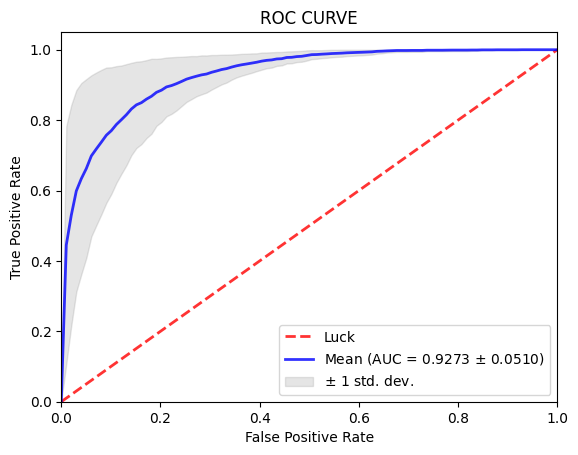

In [20]:
shuffle = True
## dictionaries of fpr tpr ## 
fpr = {}
tpr = {}
roc_auc = {}

for legalUser in users:
    # the function below has 3 variables - legalser (which of the sessions are legal), training - use training files only, test - use test files and parse CSV to check the legality ##
    balabit_reader.processDataWithLabels(legalUser, training = True, test = True)
    # the rest is the same as in previous attempts ##
    path = balabit_reader.getFileName()
    legality_analyser = legalityAnalyser(path)
    ## balanced = True - it will create balanced dataset // when balanced is False then  every false action of the dataset will be used, ratio legal to illegal will be  something like 1:8 
    dataset = legality_analyser.createTrainingData(balanced = True)

    ## the last label is 0 and 1
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
   
    X_train, X_validation, y_train, y_validation = legality_analyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = SVMModel(dataset, users)
    ## evaluating the model, the variables are X_train, y_train, X_validation, y_validation, scale --> use standardScler, and legalUser
    fpr[legalUser], tpr[legalUser], thr = model.evaluate(X_train, y_train, X_validation, y_validation, user = legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")

plotROCs(fpr, tpr, roc_auc, users)

# CHAOSHEN

In [2]:
from utils.consts import *
from utils. plotting import *
from data_reader_chaoshen import *
from nonlegality_analyser import *
import random

In [5]:
# users = [1,2, 3, 5, 4,16,20,21,23] # a few users
users = [i for i in range (1,29)] ## all users 
chaoshen_reader = DataReaderChaoShen(CHAOSHEN, users, limit = 1000000)
chaoshen_reader.processDataWithoutLabels()

In [23]:

path = chaoshen_reader.getFileName()
chaoShenAnalyser = nonLegalityAnalyser(path)
print(chaoShenAnalyser.countActions())

type_of_action     1    3    4
userid                        
1                558  488  214
2                746  154  334
3                707  419  173
4                773  462  148
5               1077  407  167
16               781  402  166
20               599  221  148
21               684  214  130
23               592  477  238


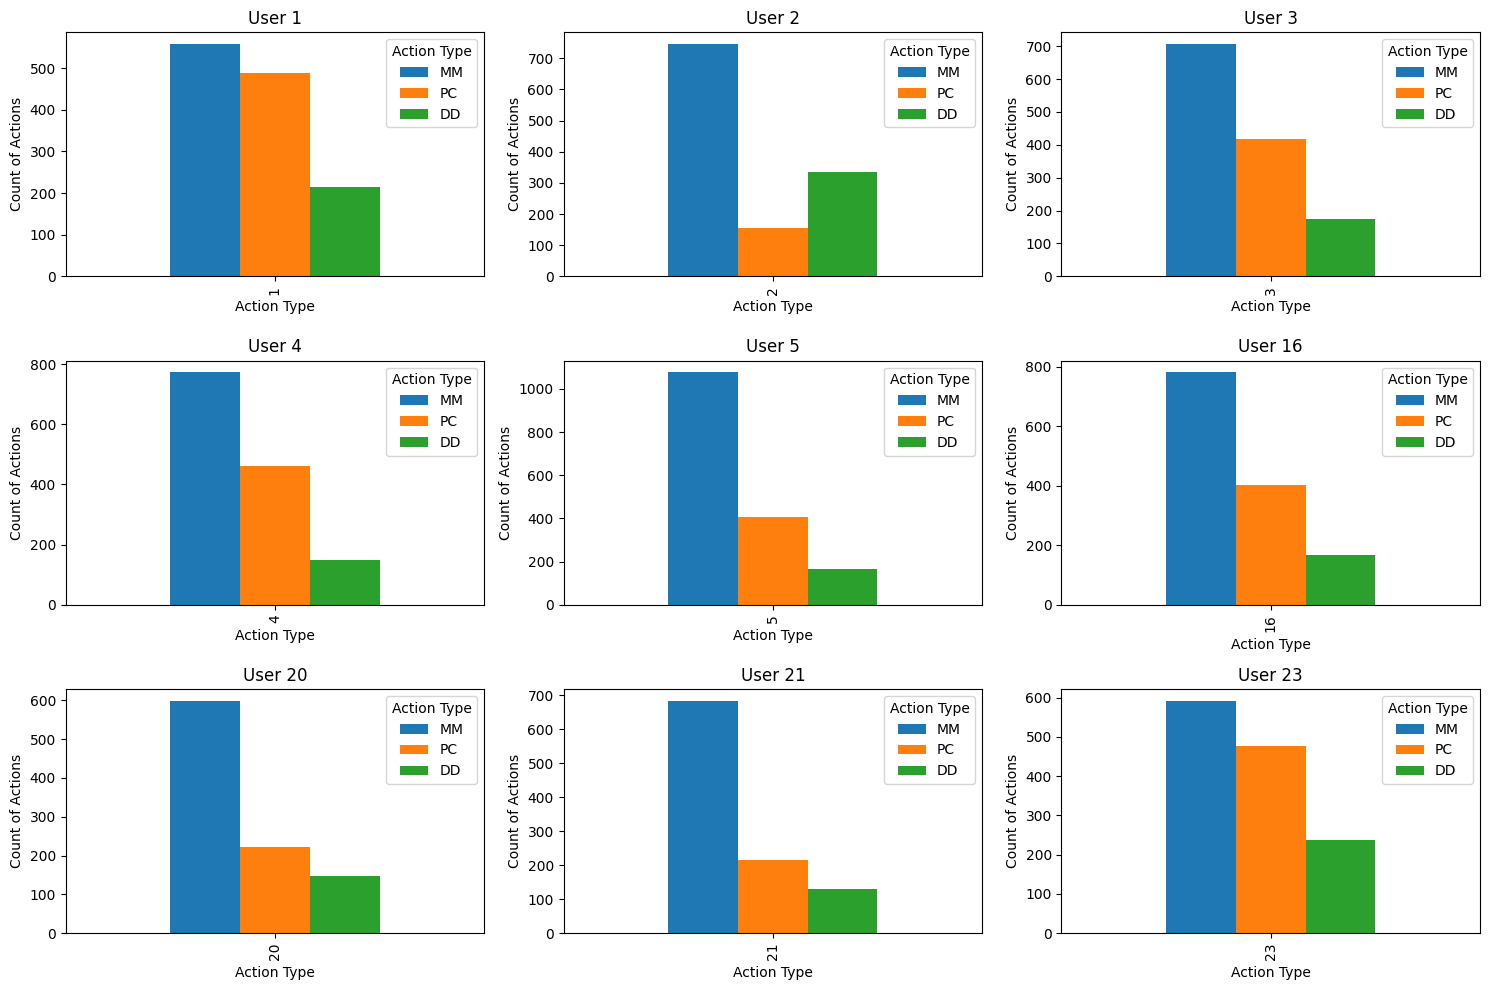

In [24]:
chaoShenAnalyser.plotActionHistograms()

## Random Forest

In [25]:
from RandomForestModel import *

User 1 is being analyzed:
CV Accuracy: 0.78 (+/- 0.06)
Test Accuracy: 0.57
1: 0.819 threshold: 0.430
User 2 is being analyzed:
CV Accuracy: 0.80 (+/- 0.06)
Test Accuracy: 0.64
2: 0.829 threshold: 0.460
User 3 is being analyzed:
CV Accuracy: 0.72 (+/- 0.06)
Test Accuracy: 0.56
3: 0.690 threshold: 0.418
User 5 is being analyzed:
CV Accuracy: 0.75 (+/- 0.04)
Test Accuracy: 0.52
5: 0.819 threshold: 0.402
User 4 is being analyzed:
CV Accuracy: 0.72 (+/- 0.07)
Test Accuracy: 0.62
4: 0.820 threshold: 0.515
User 16 is being analyzed:
CV Accuracy: 0.73 (+/- 0.06)
Test Accuracy: 0.54
16: 0.862 threshold: 0.588
User 20 is being analyzed:
CV Accuracy: 0.72 (+/- 0.11)
Test Accuracy: 0.59
20: 0.779 threshold: 0.503
User 21 is being analyzed:
CV Accuracy: 0.81 (+/- 0.06)
Test Accuracy: 0.60
21: 0.971 threshold: 0.425
User 23 is being analyzed:
CV Accuracy: 0.77 (+/- 0.05)
Test Accuracy: 0.64
23: 0.882 threshold: 0.526


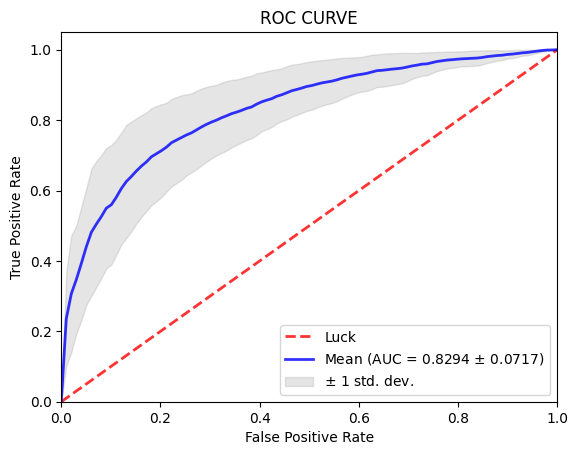

In [26]:
shuffle = True
fpr = {}
tpr = {}
roc_auc = {}
for legalUser in users:
    dataset = chaoShenAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = chaoShenAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users)
    fpr[legalUser], tpr[legalUser], thr = model.evaluate(X_train, y_train, X_validation, y_validation, scale = True, user = legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")

plotROCs(fpr, tpr, roc_auc, users)

## SVM

User 1 is being analyzed:
CV Accuracy: 0.60 (+/- 0.04)
Test Accuracy: 0.67
1: 0.901 threshold: 0.504
User 2 is being analyzed:
CV Accuracy: 0.69 (+/- 0.06)
Test Accuracy: 0.70
2: 0.937 threshold: 0.502
User 3 is being analyzed:
CV Accuracy: 0.59 (+/- 0.04)
Test Accuracy: 0.58
3: 0.678 threshold: 0.500
User 5 is being analyzed:
CV Accuracy: 0.65 (+/- 0.04)
Test Accuracy: 0.67
5: 0.890 threshold: 0.509
User 4 is being analyzed:
CV Accuracy: 0.62 (+/- 0.07)
Test Accuracy: 0.67
4: 0.865 threshold: 0.507
User 16 is being analyzed:
CV Accuracy: 0.61 (+/- 0.06)
Test Accuracy: 0.63
16: 0.848 threshold: 0.496
User 20 is being analyzed:
CV Accuracy: 0.62 (+/- 0.09)
Test Accuracy: 0.62
20: 0.793 threshold: 0.509
User 21 is being analyzed:
CV Accuracy: 0.65 (+/- 0.06)
Test Accuracy: 0.68
21: 0.889 threshold: 0.514
User 23 is being analyzed:
CV Accuracy: 0.65 (+/- 0.10)
Test Accuracy: 0.63
23: 0.847 threshold: 0.498


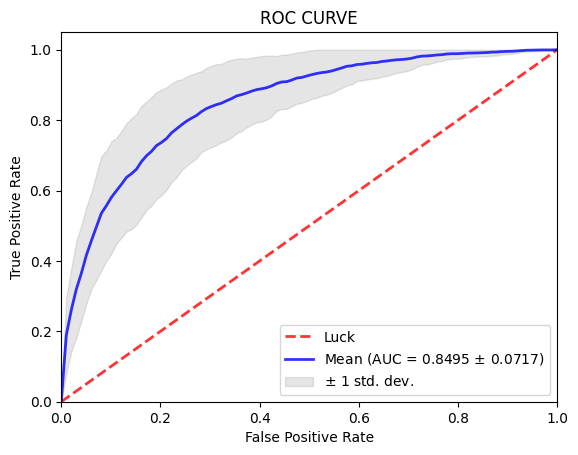

In [27]:
shuffle = True
fpr = {}
tpr = {}
roc_auc = {}

for legalUser in users:
    dataset = chaoShenAnalyser.createTrainingDataWithLabel(legalUser)    
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = chaoShenAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = SVMModel(dataset, users)
    fpr[legalUser], tpr[legalUser], thr = model.evaluate(X_train, y_train, X_validation, y_validation, legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")


plotROCs(fpr, tpr, roc_auc, users)

# SINGAPUR

In [ ]:
from utils.consts import *
from utils. plotting import *
from data_reader_singapur import *
from nonlegality_analyser import *

In [ ]:
# users = [1,2, 3, 4, 5, 6,9, 7, 16,20,21,23]
users = [i for i in range (0,24)]
singapur_reader = DataReaderSingapur(SINGAPUR, users, limit = 100000)


In [38]:
singapur_reader.processDataWithoutLabels()

In [39]:

path = singapur_reader.getFileName()
singapurAnalyser = nonLegalityAnalyser(path)
print(singapurAnalyser.countActions())

type_of_action    1    3    4
userid                       
1               588  649  286
2               291  854  119
3               240  571   78
4               136  431   51
5                77  171   25
6               346  634  150
7               459  750  223
9               196  216  110
16              393  436  266
20              378  753  216
21              372  854  104
23              165  368   90


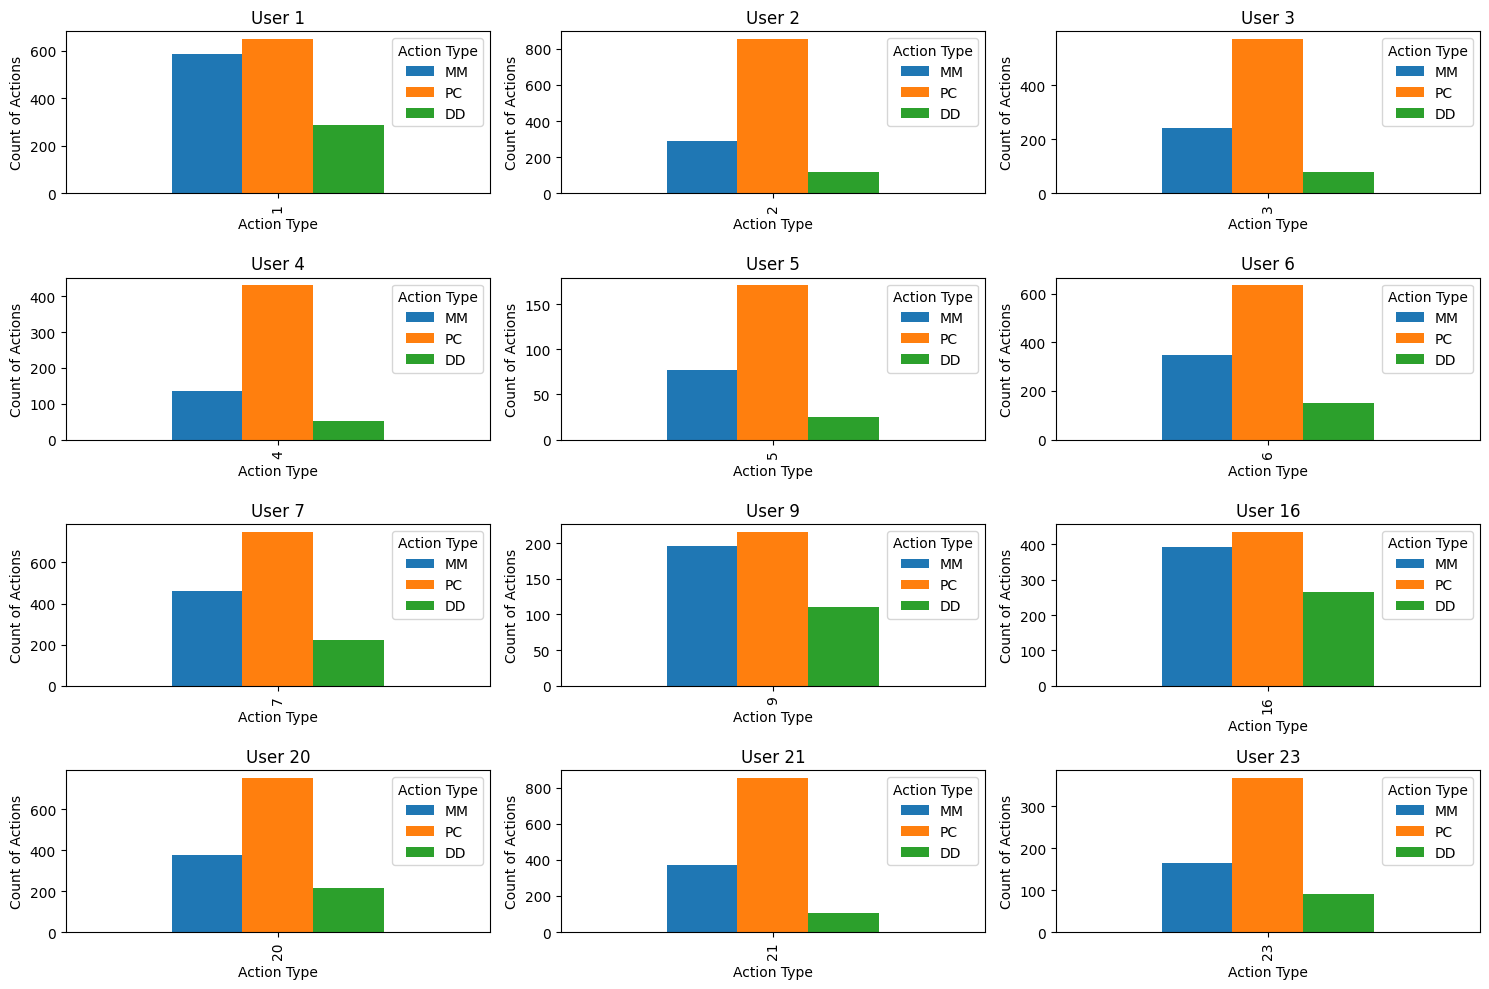

In [40]:
singapurAnalyser.plotActionHistograms()

## Random Forest

In [41]:
from RandomForestModel import *

User 1 is being analyzed:
CV Accuracy: 0.69 (+/- 0.05)
Test Accuracy: 0.54
1: 0.705 threshold: 0.355
User 2 is being analyzed:
CV Accuracy: 0.74 (+/- 0.06)
Test Accuracy: 0.50
2: 0.681 threshold: 0.356
User 3 is being analyzed:
CV Accuracy: 0.72 (+/- 0.07)
Test Accuracy: 0.61
3: 0.849 threshold: 0.430
User 4 is being analyzed:
CV Accuracy: 0.72 (+/- 0.10)
Test Accuracy: 0.59
4: 0.852 threshold: 0.414
User 5 is being analyzed:
CV Accuracy: 0.73 (+/- 0.11)
Test Accuracy: 0.76
5: 0.933 threshold: 0.455
User 6 is being analyzed:
CV Accuracy: 0.66 (+/- 0.05)
Test Accuracy: 0.51
6: 0.670 threshold: 0.296
User 9 is being analyzed:
CV Accuracy: 0.77 (+/- 0.07)
Test Accuracy: 0.63
9: 0.832 threshold: 0.446
User 7 is being analyzed:
CV Accuracy: 0.77 (+/- 0.05)
Test Accuracy: 0.62
7: 0.900 threshold: 0.423
User 16 is being analyzed:
CV Accuracy: 0.95 (+/- 0.02)
Test Accuracy: 0.59
16: 0.993 threshold: 0.635
User 20 is being analyzed:
CV Accuracy: 0.77 (+/- 0.05)
Test Accuracy: 0.59
20: 0.770 thr

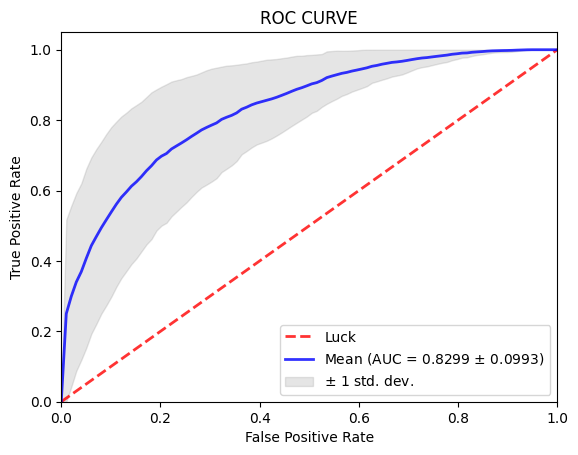

In [42]:
shuffle = True
fpr = {}
tpr = {}
roc_auc = {}
for legalUser in users:
    dataset = singapurAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = singapurAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users)
    fpr[legalUser], tpr[legalUser], thr = model.evaluate(X_train, y_train, X_validation, y_validation, scale = True, user = legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")

plotROCs(fpr, tpr, roc_auc, users)

## SVM

In [43]:
from SVMmodel import *

User 1 is being analyzed:
CV Accuracy: 0.60 (+/- 0.08)
Test Accuracy: 0.64
1: 0.802 threshold: 0.499
User 2 is being analyzed:
CV Accuracy: 0.65 (+/- 0.07)
Test Accuracy: 0.63
2: 0.823 threshold: 0.484
User 3 is being analyzed:
CV Accuracy: 0.63 (+/- 0.08)
Test Accuracy: 0.64
3: 0.817 threshold: 0.532
User 4 is being analyzed:
CV Accuracy: 0.62 (+/- 0.08)
Test Accuracy: 0.64
4: 0.842 threshold: 0.476
User 5 is being analyzed:
CV Accuracy: 0.65 (+/- 0.16)
Test Accuracy: 0.65
5: 0.860 threshold: 0.514
User 6 is being analyzed:
CV Accuracy: 0.59 (+/- 0.09)
Test Accuracy: 0.58
6: 0.678 threshold: 0.510
User 9 is being analyzed:
CV Accuracy: 0.59 (+/- 0.08)
Test Accuracy: 0.62
9: 0.851 threshold: 0.515
User 7 is being analyzed:
CV Accuracy: 0.64 (+/- 0.06)
Test Accuracy: 0.65
7: 0.847 threshold: 0.501
User 16 is being analyzed:
CV Accuracy: 0.89 (+/- 0.02)
Test Accuracy: 0.89
16: 0.996 threshold: 0.453
User 20 is being analyzed:
CV Accuracy: 0.62 (+/- 0.05)
Test Accuracy: 0.66
20: 0.863 thr

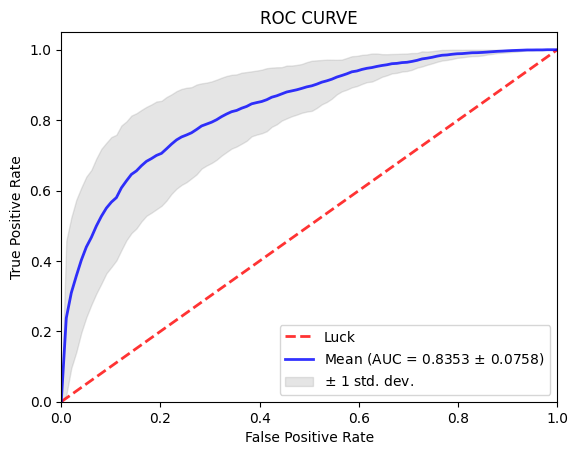

In [44]:
shuffle = True
fpr = {}
tpr = {}
roc_auc = {}
for legalUser in users:
    dataset = singapurAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = singapurAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = SVMModel(dataset, users)
    fpr[legalUser], tpr[legalUser], thr = model.evaluate(X_train, y_train, X_validation, y_validation, user = legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")

plotROCs(fpr, tpr, roc_auc, users)

The function below extract the stolen sessions and save it to the test_files path

In [ ]:
#singapur_reader.processTestData()

# DFL

In [1]:
from utils.consts import *
from utils. plotting import *
from data_reader_dfl import *
from nonlegality_analyser import *
import random

In [2]:
users = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16, 17, 18, 19, 20, 21]
dfl_reader = DataReaderDfl(DFL, users, False, limit = 300)
dfl_reader.processDataWithoutLabels()


In [3]:

path = dfl_reader.getFileName()
dflAnalyser = nonLegalityAnalyser(path)
print(dflAnalyser.countActions())

type_of_action    1     3    4
userid                        
1               623   853   88
2               636  1025   45
3               132   445   25
4               420   732  147
5               481   751  256
6               577   726  285
7               350   614   70
8               223   921   53
9               449   922   74
10              283   804  219
11              655   550  275
12              582   743  123
13              829   860   79
14              442   896   64
15              233  1035   34
16              367   691  351
17              251   830   43
18              308   852   93
19              515   684  320
20              513   788   82
21              312   966   97


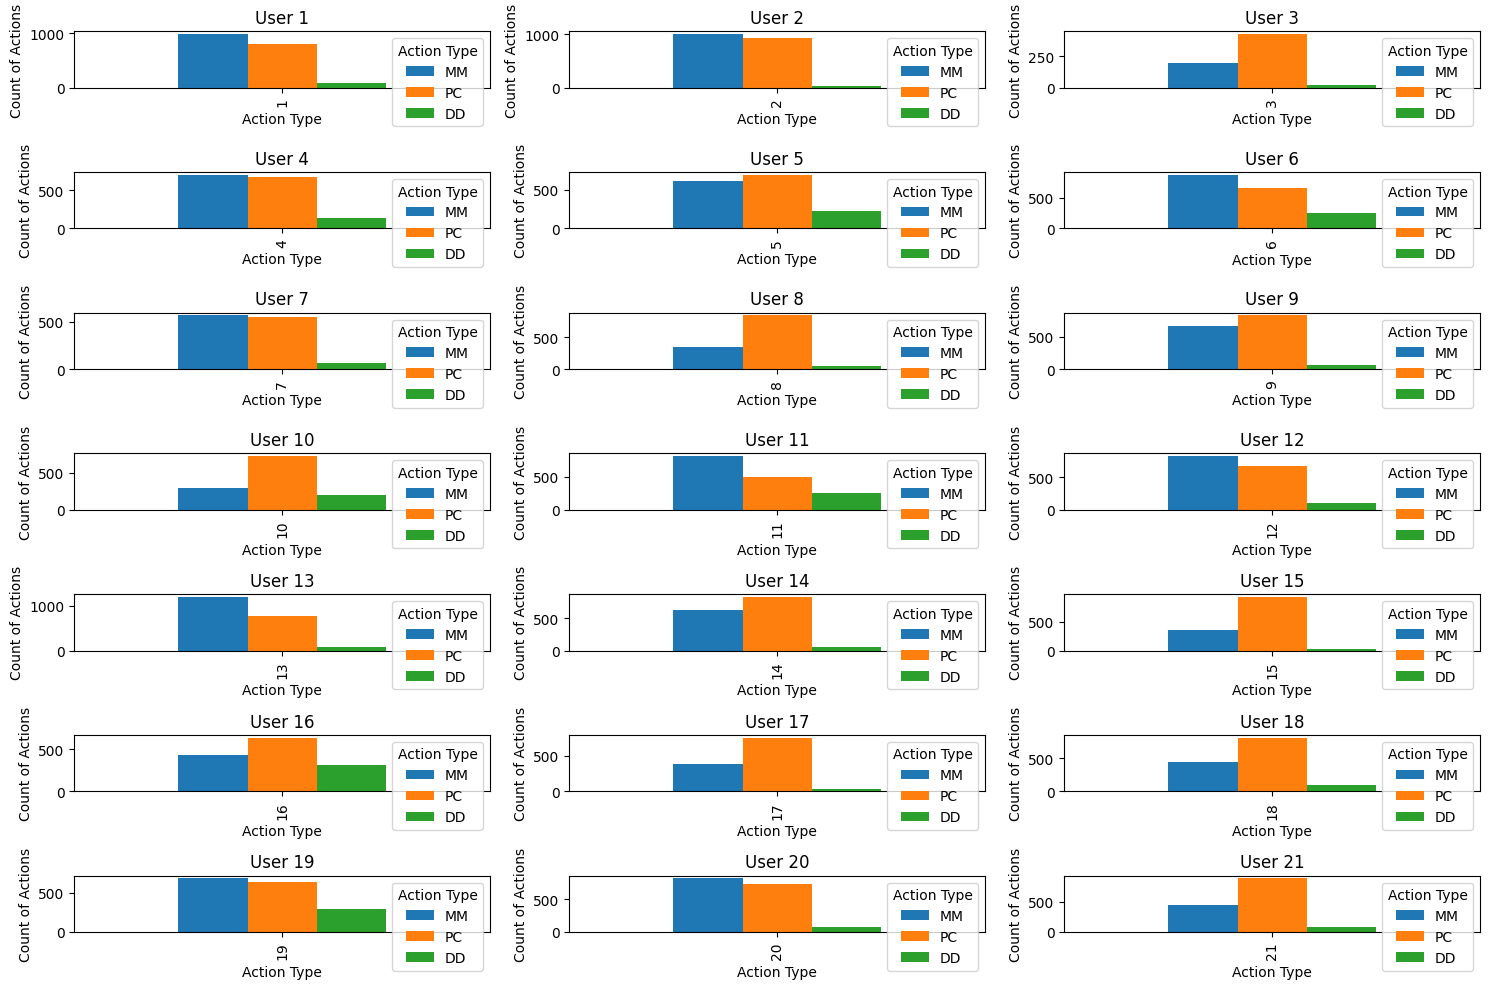

In [4]:
dflAnalyser.plotActionHistograms()

## Random Forest

In [4]:
from RandomForestModel import *

User 1 is being analyzed:
CV Accuracy: 0.73 (+/- 0.06)
Test Accuracy: 0.56
1: 0.672 threshold: 0.405
User 2 is being analyzed:
CV Accuracy: 0.80 (+/- 0.06)
Test Accuracy: 0.71
2: 0.801 threshold: 0.489
User 3 is being analyzed:
CV Accuracy: 0.83 (+/- 0.10)
Test Accuracy: 0.75
3: 0.821 threshold: 0.473
User 4 is being analyzed:
CV Accuracy: 0.94 (+/- 0.04)
Test Accuracy: 0.57
4: 0.717 threshold: 0.381
User 5 is being analyzed:
CV Accuracy: 0.71 (+/- 0.05)
Test Accuracy: 0.53
5: 0.581 threshold: 0.320
User 6 is being analyzed:
CV Accuracy: 0.75 (+/- 0.06)
Test Accuracy: 0.57
6: 0.729 threshold: 0.419
User 7 is being analyzed:
CV Accuracy: 0.86 (+/- 0.06)
Test Accuracy: 0.76
7: 0.851 threshold: 0.486
User 8 is being analyzed:
CV Accuracy: 0.84 (+/- 0.06)
Test Accuracy: 0.54
8: 0.625 threshold: 0.360
User 9 is being analyzed:
CV Accuracy: 0.80 (+/- 0.04)
Test Accuracy: 0.60
9: 0.791 threshold: 0.441
User 10 is being analyzed:
CV Accuracy: 0.87 (+/- 0.05)
Test Accuracy: 0.53
10: 0.697 thres

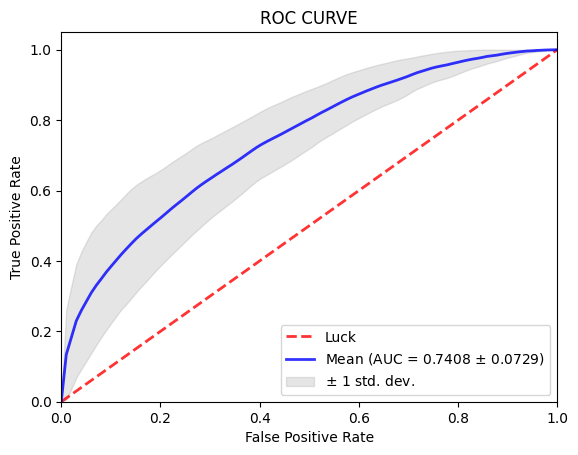

In [5]:
shuffle = True
fpr = {}
tpr = {}
roc_auc = {}
for legalUser in users:
    dataset = dflAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = dflAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users)
    fpr[legalUser], tpr[legalUser], thr = model.evaluate(X_train, y_train, X_validation, y_validation, scale = True, user = legalUser, num_actions = 1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")

plotROCs(fpr, tpr, roc_auc, users)

User 1 is being analyzed:
CV Accuracy: 0.95 (+/- 0.00)
Test Accuracy: 0.95
1: 0.670 threshold: 0.051
User 2 is being analyzed:
CV Accuracy: 0.95 (+/- 0.00)
Test Accuracy: 0.94
2: 0.700 threshold: 0.064
User 3 is being analyzed:
CV Accuracy: 0.98 (+/- 0.00)
Test Accuracy: 0.98
3: 0.736 threshold: 0.059
User 4 is being analyzed:
CV Accuracy: 0.98 (+/- 0.00)
Test Accuracy: 0.95
4: 0.516 threshold: 0.084
User 5 is being analyzed:
CV Accuracy: 0.95 (+/- 0.00)
Test Accuracy: 0.95
5: 0.602 threshold: 0.039
User 6 is being analyzed:
CV Accuracy: 0.95 (+/- 0.00)
Test Accuracy: 0.95
6: 0.615 threshold: 0.052
User 7 is being analyzed:
CV Accuracy: 0.98 (+/- 0.00)
Test Accuracy: 0.97
7: 0.766 threshold: 0.077
User 8 is being analyzed:
CV Accuracy: 0.97 (+/- 0.00)
Test Accuracy: 0.96
8: 0.720 threshold: 0.055
User 9 is being analyzed:
CV Accuracy: 0.95 (+/- 0.00)
Test Accuracy: 0.95
9: 0.687 threshold: 0.069
User 10 is being analyzed:
CV Accuracy: 0.96 (+/- 0.00)
Test Accuracy: 0.95
10: 0.653 thres

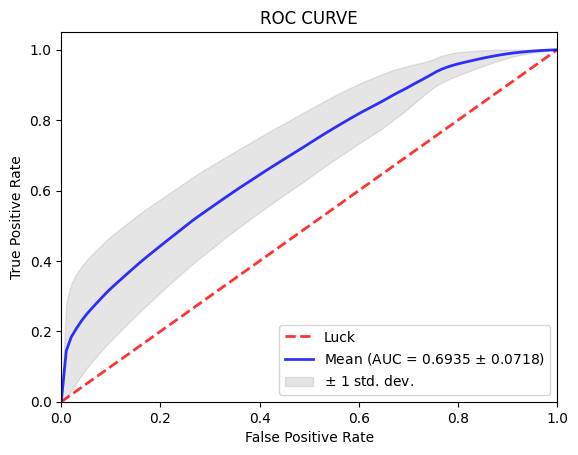

In [6]:
shuffle = True
fpr = {}
tpr = {}
roc_auc = {}
for legalUser in users:
    dataset = dflAnalyser.createTrainingDataWithLabel(legalUser, balanced= False)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = dflAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users, weight='balanced')
    fpr[legalUser], tpr[legalUser], thr = model.evaluate(X_train, y_train, X_validation, y_validation, scale = True, user = legalUser, num_actions = 1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")

plotROCs(fpr, tpr, roc_auc, users)

## SVM

In [51]:
from SVMmodel import *

User 1 is being analyzed:
CV Accuracy: 0.65 (+/- 0.04)
Test Accuracy: 0.66
1: 0.707 threshold: 0.520
User 2 is being analyzed:
CV Accuracy: 0.68 (+/- 0.04)
Test Accuracy: 0.70
2: 0.789 threshold: 0.450
User 3 is being analyzed:
CV Accuracy: 0.65 (+/- 0.11)
Test Accuracy: 0.68
3: 0.749 threshold: 0.413
User 4 is being analyzed:
CV Accuracy: 0.78 (+/- 0.08)
Test Accuracy: 0.79
4: 0.880 threshold: 0.428
User 5 is being analyzed:
CV Accuracy: 0.56 (+/- 0.07)
Test Accuracy: 0.58
5: 0.606 threshold: 0.508
User 6 is being analyzed:
CV Accuracy: 0.63 (+/- 0.05)
Test Accuracy: 0.62
6: 0.722 threshold: 0.552
User 7 is being analyzed:
CV Accuracy: 0.70 (+/- 0.05)
Test Accuracy: 0.69
7: 0.782 threshold: 0.429
User 8 is being analyzed:
CV Accuracy: 0.61 (+/- 0.09)
Test Accuracy: 0.66
8: 0.724 threshold: 0.502
User 9 is being analyzed:
CV Accuracy: 0.70 (+/- 0.05)
Test Accuracy: 0.70
9: 0.765 threshold: 0.545
User 10 is being analyzed:
CV Accuracy: 0.72 (+/- 0.08)
Test Accuracy: 0.76
10: 0.834 thres

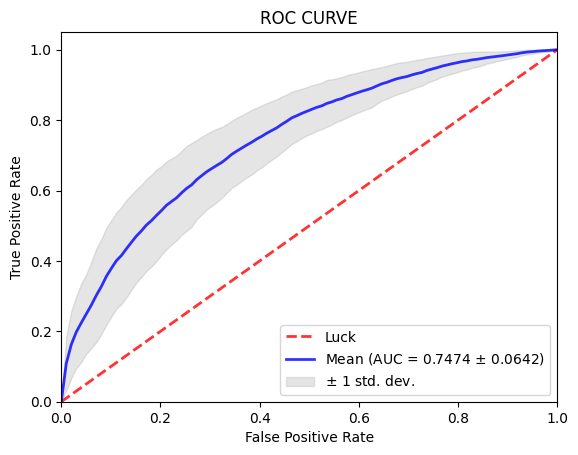

In [52]:
shuffle = True
fpr = {}
tpr = {}
roc_auc = {}
for legalUser in users:
    dataset = dflAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = dflAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = SVMModel(dataset, users)
    fpr[legalUser], tpr[legalUser], thr = model.evaluate(X_train, y_train, X_validation, y_validation, user = legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")

plotROCs(fpr, tpr, roc_auc, users)